In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
import ultraplot as pplt

########## load fortran data ##########

npa = 1000 # number particles
nt = 201 #number time steps
dt = 0.05 #time step in seconds

df = pd.read_csv(f'/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/fort.1001', sep='\s+', header=None, names=['x', 'y'])
data = df.values.reshape([1000, 201, 2])

# Compute the x and y velocities along time axis
dx = np.diff(data[..., 0], axis=1)  # shape (1000, 200)
dy = np.diff(data[..., 1], axis=1)  # shape (1000, 200)

# To match shape (1000, 201), pad with a zero velocity at the end (or beginning)
vx = 1/dt*np.concatenate([dx, np.zeros((data.shape[0], 1))], axis=1)  # shape (1000, 201)
vy = 1/dt*np.concatenate([dy, np.zeros((data.shape[0], 1))], axis=1)  # shape (1000, 201)

# Expand last axis to concatenate along last dimension
vx = vx[..., np.newaxis]
vy = vy[..., np.newaxis]

# Concatenate position and velocity to get final shape (1000, 201, 4)
data3 = np.concatenate([data, vx, vy], axis=-1)

print(data.shape)
print(data3.shape)

(1000, 201, 2)
(1000, 201, 5)


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_16857/2536557050.py:12: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(f'/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/fort.1001', sep='\s+', header=None, names=['x', 'y'])


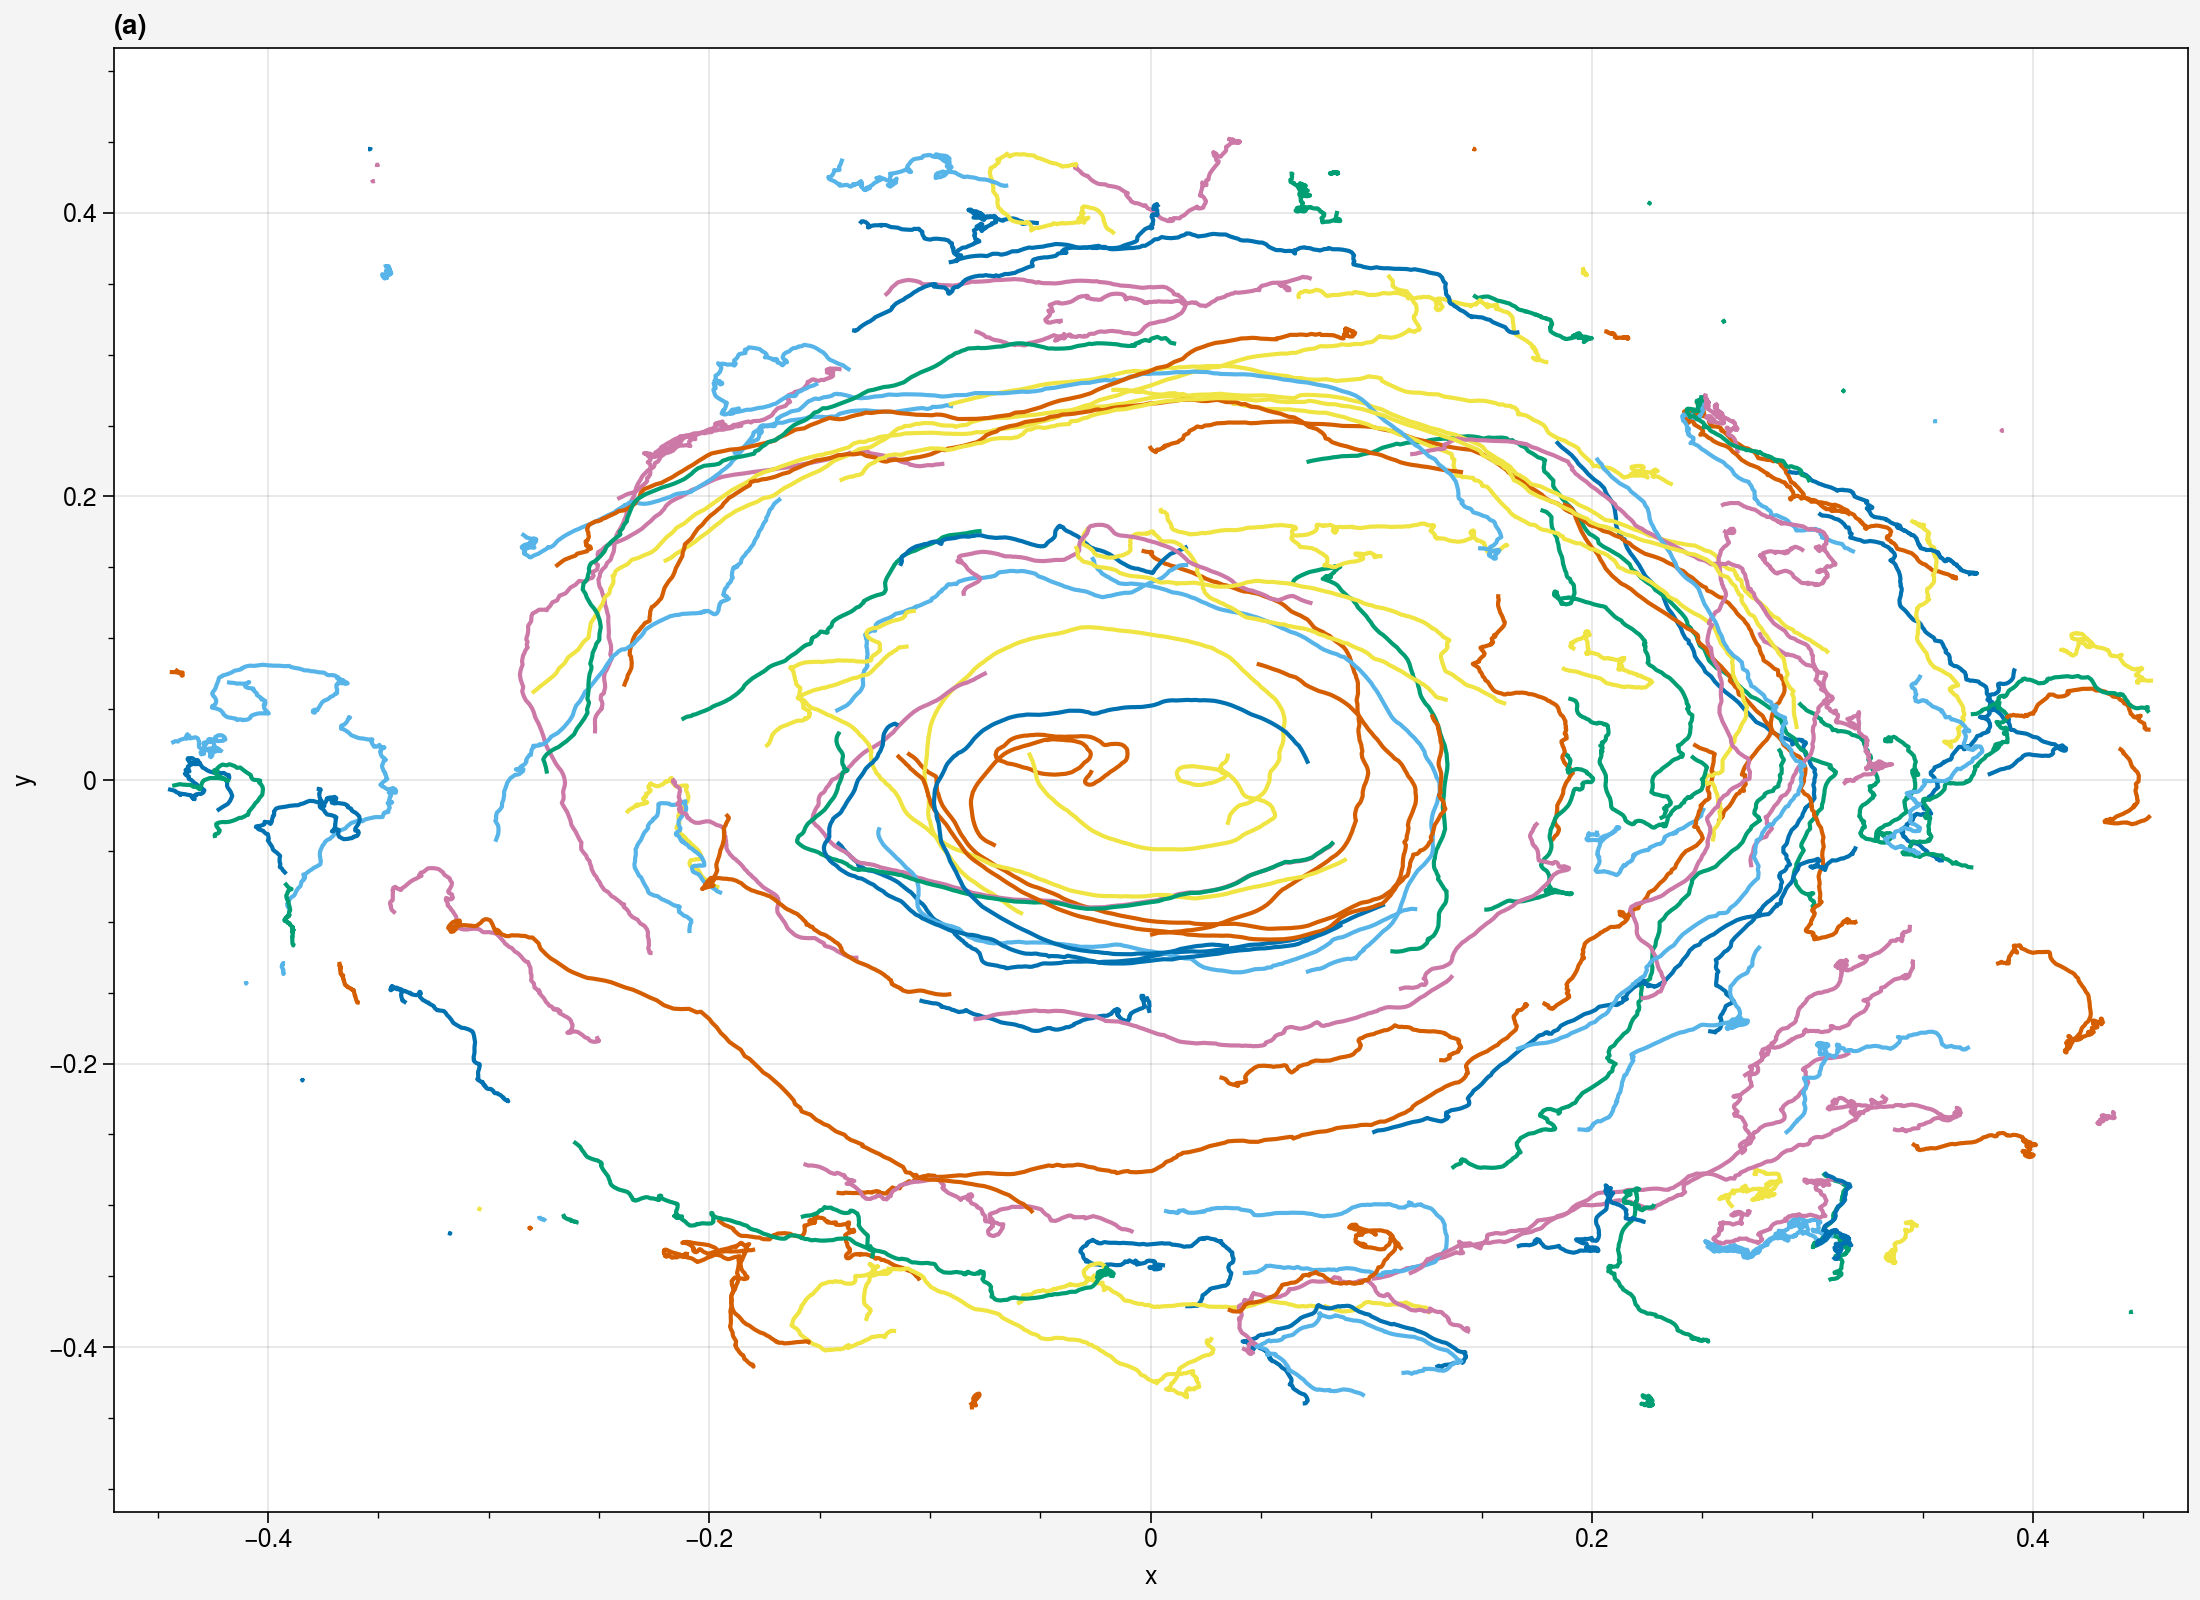

In [ ]:


x = xr.DataArray(data3[:,:,0], name='x', dims=['particle', 'time'], coords={'particle':np.arange(npa), 'time':np.arange(nt)})
y = xr.DataArray(data3[:,:,1], name='y', dims=['particle', 'time'], coords={'particle':np.arange(npa), 'time':np.arange(nt)})
ux = xr.DataArray(data3[:,:,2], name='ux', dims=['particle', 'time'], coords={'particle':np.arange(npa), 'time':np.arange(nt)})
uy = xr.DataArray(data3[:,:,3], name='uy', dims=['particle', 'time'], coords={'particle':np.arange(npa), 'time':np.arange(nt)})

# Create particle ID variable (1 to npa), int32
ID = xr.DataArray(np.arange(1, npa + 1, dtype=np.int32), name='ID', dims=['particle'], coords={'particle': np.arange(npa)})


########## convert to netcdf file ##########

dset = xr.merge([x, y, ux, uy])
dset.to_netcdf(f'/home/dgsl1/Documents/GitHub/xdispersion/data_daphne/fort.1003.nc')

########## plot the trajectory ##########

fig, axes = pplt.subplots(figsize=(11, 8), sharex=3, sharey=3)
ax = axes[0]
ax.plot(x[::5].T, y[::5].T)
axes.format(abc='(a)')
